# Modular YCB Dataset

In [1]:
%matplotlib inline
import cv2
import pylab
import torch
from torch.autograd import Variable
import numpy as np
from generic_pose.utils import to_np, to_var

import matplotlib as mpl
import matplotlib.pyplot as plt


import time

import warnings; warnings.simplefilter('ignore')
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

## Helpful Image Viewing Functions

In [2]:
def imshowCV(img, axis = False, show = True):
    if not axis:
        plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if(show):
        plt.show()
    
def imshow(img, axis = False, colorbar = False, show = True):
    if not axis:
        plt.axis('off')
    plt.imshow(img)
    if(colorbar):
        plt.colorbar()
    if(show):
        plt.show()
    
def torch2Img(img, show = True):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    disp_img = to_np(img)
    if len(disp_img.shape) == 4:
        disp_img = disp_img[0]
    disp_img = disp_img.transpose((1,2,0))
    disp_img = disp_img * std + mean
    return disp_img
    
def imshowTorch(img, axis = False, show = True):
    if not axis:
        plt.axis('off')
    disp_img = torch2Img(img)
    plt.imshow(disp_img.astype(np.uint8))
    if(show):
        plt.show()

def plotImageScatter(img, choose, show = True):
    coords = np.unravel_index(choose, img.shape[:2])    
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))    
    plt.scatter(coords[1], coords[0], 50)
    #plt.colorbar()
    if(show):
        plt.show()

## Location of YCB Dataset

In [4]:
dataset_root = 'datasets/ycb/YCB_Video_Dataset/'

## Location of DenseFusion Checkpoint

In [5]:
model_checkpoint = 'trained_checkpoints/ycb/pose_model_26_0.012863246640872631.pth'
model_checkpoint_global = 'trained_models/ycb_global/pose_model_13_0.02780649198161978.pth'

## Location of DenseFusion Checkpoint

In [6]:
from datasets.ycb.uniform_dataset import PoseDataset as PoseDataset_ycb
from lib.network import PoseNetGlobal, PoseNet

num_objects = 21 #number of object classes in the dataset
num_points = 1000 #number of points on the input pointcloud


estimator_global = PoseNetGlobal(num_points = num_points, 
                          num_obj = num_objects)
estimator_global.load_state_dict(torch.load(model_checkpoint_global))
estimator_global.cuda();

estimator = PoseNet(num_points = num_points, 
                    num_obj = num_objects)
estimator.load_state_dict(torch.load(model_checkpoint))
estimator.cuda();

## YCB Dataloader

In [10]:
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.image_processing import ColorJitter, ImageNormalizer
from object_pose_utils.datasets.point_processing import PointShifter
from object_pose_utils.datasets.inplane_rotation_augmentation import InplaneRotator
from object_pose_utils.datasets.ycb_occlusion_augmentation import YCBOcclusionAugmentor
from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes

object_list = [1]#list(range(1,22))

mode = "train"

output_format = [otypes.DEPTH_POINTS_MASKED_AND_INDEXES,
                 otypes.IMAGE_CROPPED,
                 otypes.MODEL_POINTS_TRANSFORMED,
                 otypes.MODEL_POINTS,
                 otypes.OBJECT_LABEL,
                 otypes.QUATERNION,
                 ]

dataset = YCBDataset(dataset_root, mode=mode, 
                     object_list = object_list, 
                     output_data = output_format,
                     resample_on_error = True,
                     #preprocessors = [YCBOcclusionAugmentor(dataset_root), ColorJitter()],
                     #postprocessors = [ImageNormalizer(), PointShifter()],
                     postprocessors = [ImageNormalizer()],
                     image_size = [640, 480], num_points=1000)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

## Load Modular YCB Data 

In [11]:
from tqdm import tqdm_notebook as tqdm
from object_pose_utils.utils.pose_processing import tensorAngularDiff
estimator.eval()
estimator_global.eval()
#np.random.seed(0)
distance = []
distance_global = []
num_iters = 1000
for j, data in tqdm(enumerate(dataloader), total=num_iters):
    if(j == num_iters):
        break
    points, choose, img, target, model_points, idx, quat = data
    idx = idx - 1
    points, choose, img, target, model_points, idx = Variable(points).cuda(), \
                                                     Variable(choose).cuda(), \
                                                     Variable(img).cuda(), \
                                                     Variable(target).cuda(), \
                                                     Variable(model_points).cuda(), \
                                                     Variable(idx).cuda()
    pred_r, pred_t, pred_c, emb = estimator(img, points, choose, idx)
    pred_q = pred_r[0,torch.argmax(pred_c)][[1,2,3,0]]
    pred_q /= pred_q.norm()
    distance.append(to_np(tensorAngularDiff(pred_q, quat.cuda())))
    
    pred_r, pred_t, pred_c, emb = estimator_global(img, points, choose, idx)
    pred_q = pred_r[0,0][[1,2,3,0]]
    pred_q /= pred_q.norm()
    distance_global.append(to_np(tensorAngularDiff(pred_q, quat.cuda())))
    break
distance = np.array(distance)
distance_global = np.array(distance_global)
print(distance.mean()*180/np.pi)
print(distance_global.mean()*180/np.pi)


2.290693262469832
5.505141008766739


tensor([-0.8815, -0.0114, -0.0035, -0.4719], device='cuda:0',
       grad_fn=<DivBackward0>)


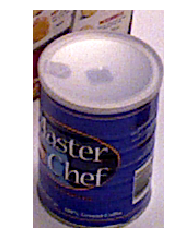

In [13]:
print(pred_q)

imshowTorch(img)